In [10]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver
DEVICE = triton.runtime.driver.active.get_active_torch_device()


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')

In [45]:
def naive_softmax(x:torch.Tensor) -> torch.Tensor:
    # N (row) * M (col) softmax
    x_max = x.max(dim=1)[0] # NM reads (max of each row), M writes
    z = x - x_max[:,None] #  NM writes, NM + M read
    numerator = torch.exp(z) # NM reads, NM writes
    denominator = numerator.sum(dim=1) # N writes, NM reads
    ret = numerator / denominator[:,None] # NM writes, NM + m reads
    return ret

SIZE =5
x = torch.rand([SIZE,SIZE])
x_out = naive_softmax(x)

def assert_softmax_row_sum_one(x):
    return torch.allclose(x.sum(dim=1),torch.ones_like(x.sum(dim=1)))
assert_softmax_row_sum_one(x_out)

True

In [4]:
@triton.jit
def softmax_kernel(output_ptr,input_ptr,input_row_strides,output_row_strides,n_rows,n_cols,BLOCK_SIZE:tl.constexpr,num_stages:tl.constexpr):
    #idx of starting row
    row_start = tl.program_id(axis=0)
    #num of rows until the next program (row_start + row_step*input_row_strides)
    row_step = tl.num_programs(axis=0)
    
    for row_idx in tl.range(row_start,n_rows,row_step,num_stages=num_stages):
        row_start_ptr = input_ptr + (row_idx * input_row_strides) # start of data + the offset to get to the current read
        #NOTE: limitation of triton is block sizes must be a power of 2. e.g block size is always the next bigger power of 2 value above the amount you need
        # so in this case it will be the next power of 2 above num of columns 
        col_offsets = tl.arange(0,BLOCK_SIZE)
        
        # create ptrs to each element within the current row
        input_ptrs = row_start_ptr + col_offsets
        
        mask = col_offsets < n_cols
        
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        row_minus_max = row - tl.max(row, axis=0)
        # NOTE: exp in tl is approximate (similar to __expf in cuda)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator,axis=0)
        softmax_out = numerator / denominator
        output_row_start_ptr = output_ptr + (row_idx * output_row_strides)
        output_ptrs = output_row_start_ptr +  col_offsets
        tl.store(output_ptrs,softmax_out,mask=mask)
    

In [56]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
print(f'{properties=}')

NUM_SM = properties['multiprocessor_count']
NUM_REGS = properties['max_num_regs']
SIZE_SMEM = properties['max_shared_mem']
WARP_SIZE = properties['warpSize']
target = triton.runtime.driver.active.get_current_target()
print(f'{target=}')
kernels = {}


def softmax(x):
    n_rows,n_cols = x.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 8 
    num_stages = 4 if SIZE_SMEM > 200_000 else 2

    y = torch.empty_like(x)

    kernel = softmax_kernel.warmup(y,x,x.stride(0),y.stride(0),n_rows,n_cols,BLOCK_SIZE=BLOCK_SIZE,num_stages=num_stages,num_warps=num_warps,grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared

    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    # for very small tensors we may not use shared memory at all since all is done in register?
    if size_smem > 0:
        occupancy = min(occupancy, SIZE_SMEM // size_smem)

    num_programs = NUM_SM * occupancy 
    num_programs = min(num_programs,n_rows)
    # if num_programs is < n_rows, then we are per program handling > 1 row.

    kernel[(num_programs,1,1)](y,x,x.stride(0),y.stride(0),n_rows,n_cols,BLOCK_SIZE,num_stages)
    return y 
x = torch.randn([320,320],device=DEVICE)
assert_softmax_row_sum_one(softmax(x))


properties={'max_shared_mem': 49152, 'max_num_regs': 65536, 'multiprocessor_count': 20, 'warpSize': 32, 'sm_clock_rate': 1797000, 'mem_clock_rate': 5005000, 'mem_bus_width': 256}
target=GPUTarget(backend='cuda', arch=61, warp_size=32)


True

In [50]:
def test_softmax_padding():
    torch.manual_seed(0)
    x = torch.randn(1823,781,device=DEVICE)
    y_triton = softmax(x)
    y_torch = torch.softmax(x, axis=1)
    assert torch.allclose(y_triton,y_torch),  (y_triton,y_torch)
test_softmax_padding()

24
32
200


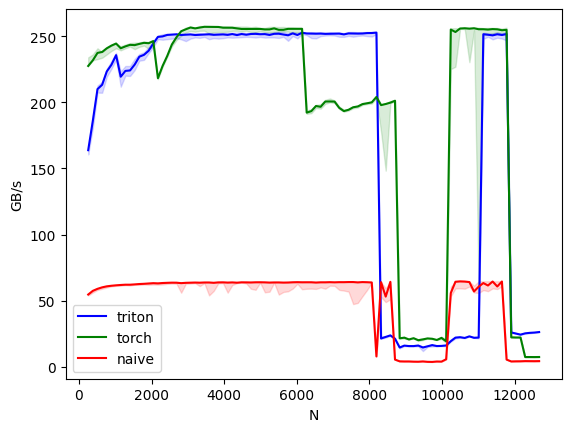

softmax-performance:
          N      triton       torch      naive
0     256.0  163.840004  227.555548  54.613331
1     384.0  186.181817  231.849058  57.420561
2     512.0  210.051289  237.449270  58.935253
3     640.0  213.333326  238.139535  60.058650
4     768.0  223.418180  240.941181  60.831684
5     896.0  228.462147  242.983044  61.264956
6    1024.0  235.741014  244.537310  61.593988
7    1152.0  219.428573  240.941175  61.852349
8    1280.0  223.825141  242.366855  62.060604
9    1408.0  224.159201  243.545950  62.060606
10   1536.0  228.613961  243.326738  62.296577
11   1664.0  234.572691  244.256880  62.571091
12   1792.0  235.983537  245.059822  62.739608
13   1920.0  239.066141  244.780886  62.983087
14   2048.0  244.537310  246.375951  63.228173
15   2176.0  249.577061  218.282122  63.072462
16   2304.0  249.925419  227.555560  63.340205
17   2432.0  251.045159  235.117833  63.477976
18   2560.0  251.288337  243.809526  63.602483
19   2688.0  251.508762  249.321734  63

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range (2,100)],
        line_arg='provider',
        line_vals=['triton','torch','naive'],
        line_names=['triton','torch','naive'],
        styles = [('blue','-'),('green','-'),('red','-')],
        ylabel='GB/s',
        plot_name = 'softmax-performance',
        args={'M':4096}
    )
)
def benchmark(M,N,provider):
    quantiles = [0.5,0.2,0.8]
    x=torch.randn(M,N,device=DEVICE,dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: torch.softmax(x,axis=1),quantiles=quantiles)
    if provider == 'triton':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: softmax(x),quantiles=quantiles)
    if provider == 'naive':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: naive_softmax(x),quantiles=quantiles)
    gbps = lambda ms: 2*x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms),gbps(min_ms),gbps(max_ms)

benchmark.run(show_plots=True,print_data=True)